# OneEye: Military Airfiled Monitoring with Computer Vision
## AAI-521 Team 1 Final Project

Team 1:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  December 11, 2023

GitHub Repository: https://github.com/t4ai/one-eye-aircraft-detector

In [18]:
!pip install pybboxes

In [54]:
# import base libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pathlib
import PIL
import PIL.Image
import xml.etree.ElementTree as ET
import pybboxes as pbx
from pybboxes import BoundingBox
from pathlib import Path

# import keras and supporting libraries
import keras
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from keras.datasets import mnist, cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras.layers import Dense
from keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

## Exploratory Data Analysis

Scan the images and bounding box labels to understand the nature of the dataset.  Objectives are:

1.  Visualize some sample images
2.  Understand the distribution of image sizes
3.  Understand the distribution of image channels
4.  Analyze the class balances and representation across the dataset
5.  Visualize sample images with horizontal bounding boxes overlaid
6.  Visualize sample images with oriented bounding boxes overlaid

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# set root folder where dataset is located
ROOT_DIR = '/content/drive/MyDrive/USD/datasets/military_aircraft'
raw_img_dir = pathlib.Path(ROOT_DIR + '/JPEGImages/')
horizontal_xml_dir = pathlib.Path(ROOT_DIR + '/Annotations/Horizontal Bounding Boxes/').with_suffix('')
oriented_xml_dir = pathlib.Path(ROOT_DIR + '/Annotations/Oriented Bounding Boxes/').with_suffix('')

### Visualize some sample images

In [ ]:
# get paths to images
img_paths = list(raw_img_dir.glob('*.jpg'))

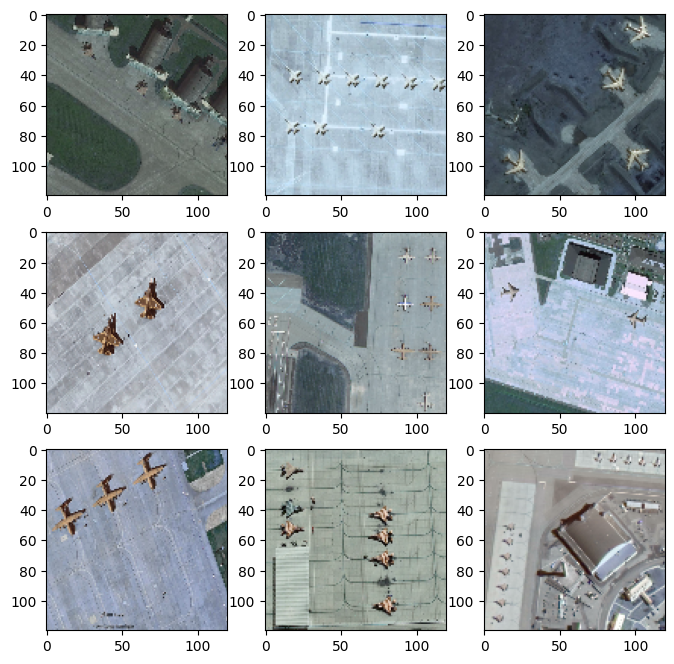

In [6]:
# visualize some samples from the training data
plt.figure(figsize=(8,8))
for i in range(9):
    rand_img = np.random.randint(0, len(img_paths))
    image = cv2.imread(str(img_paths[rand_img]))
    plt.subplot(3,3,i+1)
    plt.grid(False)
    plt.imshow(cv2.resize(image, (120, 120)))
plt.show()

### Create a distribution of the image sizes to understand the range of sizes

In [76]:
# helper function to read image files and extract characteristics
def extract_image_characteristics(image_path):

    resolutions = []
    color_distributions = []
    image_channels = []

    imgs = list(image_path.glob('*.jpg'))
    for img in imgs:
        test_img = cv2.imread(str(img))

        # store resolution
        shape = test_img.shape
        resolution = [shape[0], shape[1]]
        resolutions.append(resolution)

        # store image channel count
        if(len(test_img.shape) == 2):
          image_channels.append(1)
        else:
          image_channels.append(test_img.shape[2])

    return resolutions, image_channels

In [77]:
# compile distribution of sizes
resolution_dist, channel_dist = extract_image_characteristics(raw_img_dir)

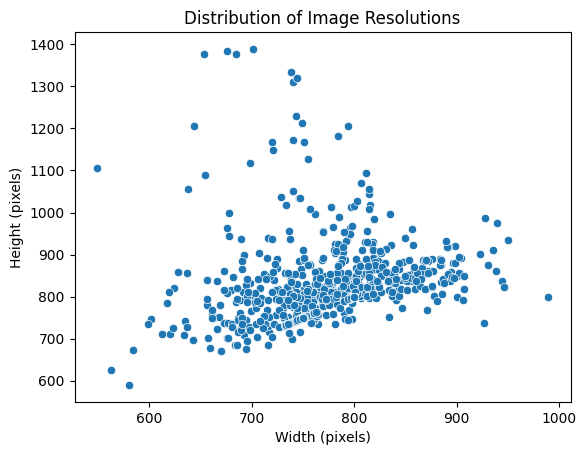

In [79]:
# Plot a scatter plot of the image resolutions
resolution_dist = np.array(resolution_dist)
#plt.figure(figsize=(6,6))
#plt.scatter(resolution_dist[:, 0], resolution_dist[:, 1])
sns.scatterplot(x=resolution_dist[:, 0], y=resolution_dist[:, 1])
plt.title("Distribution of Image Resolutions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

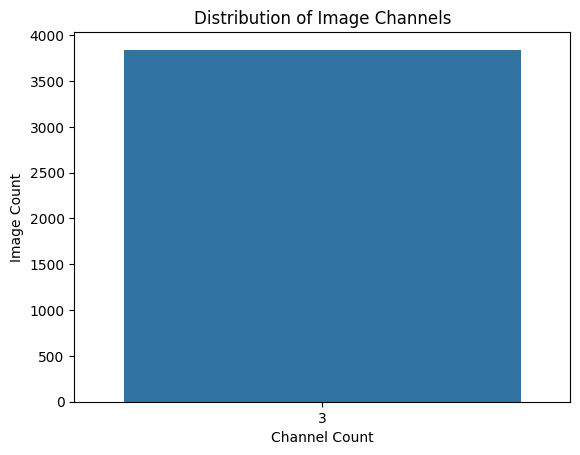

In [81]:
# Plot histogram to visually analyze distribution
sns.countplot(x=channel_dist)
plt.title("Distribution of Image Channels")
plt.xlabel( "Channel Count" , size = 10)
plt.ylabel( "Image Count" , size = 10)
plt.show()

### Helper functions to process XML label files


In [41]:
# helper function to build class map
def build_class_map(xml_dir):
    class_map = []
    xml_files = list(xml_dir.glob('*.xml'))
    for xml_file in xml_files:
        tree = ET.parse(str(xml_file))
        root = tree.getroot()
        for obj in root.iter('object'):
            class_name = obj.find('name').text
            if class_name not in class_map:
                class_map.append(class_name)
    return class_map

# helper function to build class distribution
def build_class_distribution(xml_dir):
    class_dist = {'class': [], 'count': []}
    xml_files = list(xml_dir.glob('*.xml'))
    for xml_file in xml_files:
        tree = ET.parse(str(xml_file))
        root = tree.getroot()
        for obj in root.iter('object'):
            class_name = obj.find('name').text
            if class_name not in class_dist['class']:
                class_dist['class'].append(class_name)
                class_dist['count'].append(1)
            else:
                class_dist['count'][class_dist['class'].index(class_name)] += 1
    return class_dist

# helper function to translate bounding boxes to YOLO format for single image
def get_yolo_bounding_box(xmin, ymin, xmax, ymax, width, height):
    yolo_bbox = pbx.convert_bbox((xmin, ymin, xmax, ymax), from_type="voc", to_type="yolo", image_size=(width,height))
    return yolo_bbox

#helper function to translate an image label file to YOLO format
def gen_yolo_label_file(xml_file, class_map):
    tree = ET.parse(str(xml_file))
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)
    labels = []
    for obj in root.iter('object'):
        xmin = int(obj.find('bndbox').find('xmin').text)
        ymin = int(obj.find('bndbox').find('ymin').text)
        xmax = int(obj.find('bndbox').find('xmax').text)
        ymax = int(obj.find('bndbox').find('ymax').text)
        class_name = obj.find('name').text
        yolo_bbox = get_yolo_bounding_box(xmin, ymin, xmax, ymax, width, height)
        class_id = class_map.index(class_name)
        labels.append([class_id, yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]])
    return labels

# helper function to get image width/height from label file
def get_image_dimensions_from_label(xml_file):
    tree = ET.parse(str(xml_file))
    root = tree.getroot()
    width = int(root.find('size').find('width').text)
    height = int(root.find('size').find('height').text)
    return [width, height]


### Load bounding box data and extract class distributions

In [ ]:
# build list of class labels
classes = build_class_map(horizontal_xml_dir)

In [9]:
# check list
print("Total unique class labels:", len(classes))
print("Class labels:", classes)

Total unique class labels: 20
Class labels: ['A6', 'A17', 'A16', 'A15', 'A5', 'A20', 'A14', 'A12', 'A8', 'A2', 'A7', 'A18', 'A13', 'A4', 'A19', 'A1', 'A3', 'A10', 'A11', 'A9']


In [13]:
# calculate class distribution
class_dist = build_class_distribution(horizontal_xml_dir)

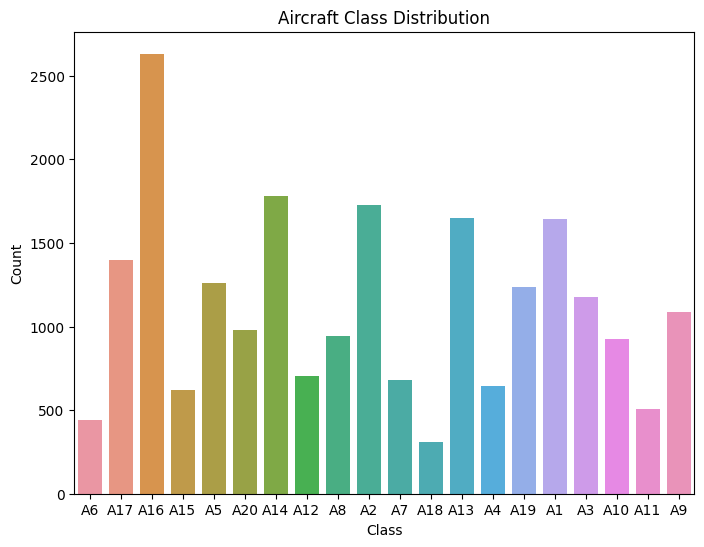

In [17]:
# visualize class distribution
plt.figure(figsize=(8,6))
sns.barplot(x=class_dist['class'], y=class_dist['count'])
plt.title("Aircraft Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Visualize some sample images with bounding boxes overlaid

In [64]:
# helper function to visualize an image with horizontal bb
def visualize_horizontal_bb(img_file, xml_file):
    labels = gen_yolo_label_file(xml_file, classes)
    img_dims = get_image_dimensions_from_label(xml_file)
    if(img_dims[0] > 0 and img_dims[1] > 0):
      img = cv2.imread(img_file)
      for label in labels:
          class_id = label[0]
          x = label[1]
          y = label[2]
          w = label[3]
          h = label[4]
          voc_box = pbx.convert_bbox([x, y, w, h], from_type="yolo", to_type="voc", image_size=(img_dims[0], img_dims[1]))
          voc_x1 = voc_box[0]
          voc_y1 = voc_box[1]
          voc_x2 = voc_box[2]
          voc_y2 = voc_box[3]
          cv2.rectangle(img, (voc_x1, voc_y1), (voc_x2, voc_y2), (0, 0, 255), 2)
          cv2.putText(img, classes[class_id], (voc_x1, voc_y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

      plt.imshow(img)
      plt.show()

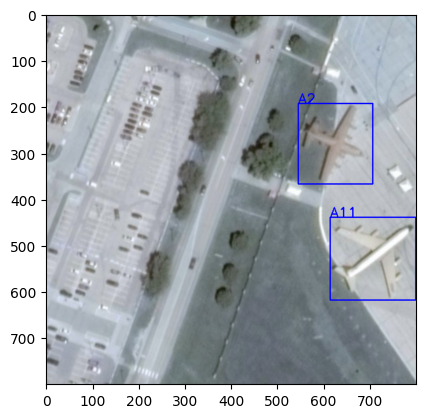

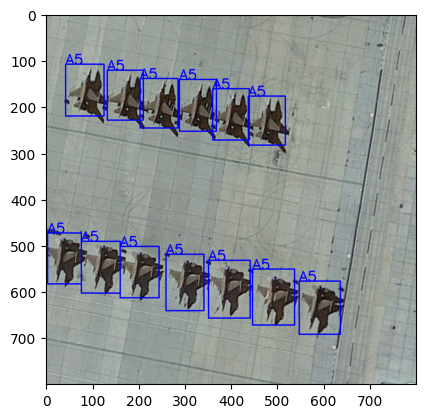

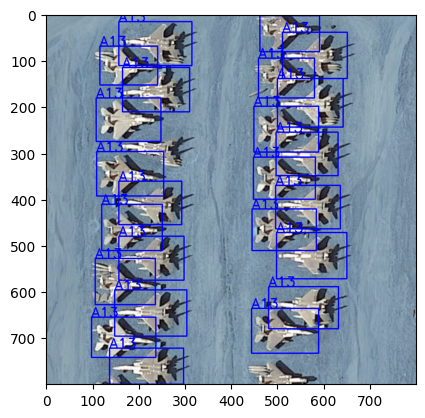

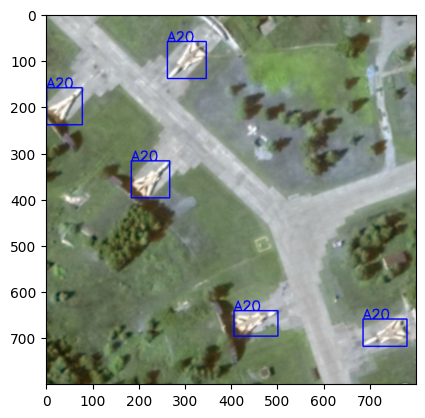

In [65]:
# visualize some random samples
for i in range(4):
    rand_img = np.random.randint(0, len(img_paths))
    img_file = str(img_paths[rand_img])
    img_number = Path(img_file).stem
    xml_file = str(horizontal_xml_dir.resolve()) + '/' + img_number + '.xml'
    visualize_horizontal_bb(img_file, xml_file)

## Data Preparation: move the images into separate train/test directories so we can use tf loader from directory